# Endoscopy Demand & Accessibility Mapping – Enhanced Version (2024)

This notebook replicates and improves upon the earlier endoscopy spatial demand model by integrating the following enhancements:

Robust site access logic: ensuring no LSOA directly on a facility is marked as underserved.

Cleaner pipeline: streamlining imports, 
GeoDataFrame merges, and cumulative accessibility logic.

Travel matrix validation: checks for intra-LSOA facility access and missing travel entries.

Integrated overlays: consistent facility marker placement (CDC and Acute) with choropleths.

Improved export handling: clear file paths and geometry separation.

In [1]:
# Standard imports
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import warnings

# Optional display settings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)

# ----------------------------------------------------------
# File Path Setup
# ----------------------------------------------------------

# Base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# Explicit modality input folder
modality_dir = os.path.join(raw_dir, "modality_modelling")

# Input file paths
lsoa_gpkg_path = os.path.join(processed_dir, "LSOA_CT_Demand_with_Demographics_2024_v1.gpkg")
cdc_path = os.path.join(modality_dir, "NHS_SW_Community_Diagnostic_Centres_Capability.csv")  # Note extra space
acute_path = os.path.join(modality_dir, "NHS_SW_Acute_Hospitals_Capability.csv")
travel_matrix_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")

# Output folder
output_dir = os.path.join(base_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)


In [2]:
# Load spatial demand file (GeoPackage with LSOA geometry and CT demand)
gdf = gpd.read_file(lsoa_gpkg_path)
print(f"LSOA GPKG loaded with shape: {gdf.shape}")

# Load site capability files
df_cdc = pd.read_csv(cdc_path)
df_acute = pd.read_csv(acute_path)
print(f"Loaded CDC capability data: {df_cdc.shape[0]} rows")
print(f"Loaded Acute hospital data: {df_acute.shape[0]} rows")

# Load LSOA-to-LSOA travel time matrix
df_travel = pd.read_csv(travel_matrix_path)
print(f"Travel matrix loaded with shape: {df_travel.shape[0]} rows")

# Quick previews
display(gdf.head(2))
display(df_cdc.head(1))
display(df_acute.head(1))
display(df_travel.head(2))


LSOA GPKG loaded with shape: (3451, 51)
Loaded CDC capability data: 24 rows
Loaded Acute hospital data: 18 rows
Travel matrix loaded with shape: 11003925 rows


,ICB23NM,ladnm,ladcd,msoa21nm,msoa21cd,lsoa21nmw,lsoa21cd,total_population,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,age_30_34,age_35_39,age_40_44,age_45_49,age_50_54,age_55_59,age_60_64,age_65_69,age_70_74,age_75_79,age_80_84,age_85_plus,lat,long,bng_e,bng_n,lsoa21nm,ct_total_demand,ct_age_0_4,ct_age_5_9,ct_age_10_14,ct_age_15_19,ct_age_20_24,ct_age_25_29,ct_age_30_34,ct_age_35_39,ct_age_40_44,ct_age_45_49,ct_age_50_54,ct_age_55_59,ct_age_60_64,ct_age_65_69,ct_age_70_74,ct_age_75_79,ct_age_80_84,ct_age_85_plus,geometry
0,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020484,1444.99,43.76,70.21,75.3,87.51,63.09,45.79,70.21,75.30,64.11,85.48,108.88,113.97,126.18,105.83,113.97,80.39,63.09,51.90,50.60036,-1.96951,402254,77850,Dorset 042G,195.135416,0.314717,0.307424,0.647540,1.908021,1.902695,1.707932,3.254599,4.268538,4.500157,6.171343,10.060345,14.501970,21.826293,21.668452,25.234176,27.716494,25.612661,23.532059,"MULTIPOLYGON (((401918.077 78945.278, 401919.4..."
1,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020481,1347.30,39.69,32.56,40.7,31.55,52.92,47.83,52.92,45.79,51.90,58.00,69.20,118.04,160.78,133.31,161.80,105.83,61.06,83.44,50.60304,-1.95604,403207,78149,Dorset 042D,229.178298,0.285446,0.142568,0.349998,0.687899,1.595984,1.784022,2.453117,2.595702,3.643085,4.187388,6.393974,15.019852,27.811312,27.294920,35.824249,36.487580,24.788541,37.832659,"MULTIPOLYGON (((403211.07 78762.983, 403211.07..."


,Code,Name,CT Scanners,MRI Scanners,Endoscopy Rooms,Address 1,Address 2,Address 3,Address 4,Address 5,Postcode,Type,Parent Organisation Code,Parent Organisation Name,postcode,latitude,longitude,lsoa21cd,msoa21cd,oa21cd,icb_code,local_authority
0,B4B4S,Bsw Banes Locality CDC,1,1,3,Foxcote Avenue,Bath Business Park,Peasedown St. John,Bath,NaN,BA2 8SQ,CDC,QOX,"NHS Bath and North East Somerset, Swindon and ...",BA28SQ,-2.416516,51.311327,E01014444,E02003006,E00072943,E54000040,E06000022


,Code,Trust Name,Name,CT Scanners,MRI Scanners,Endoscopy Rooms,Address 1,Address 2,Address 3,Address 4,Address 5,Postcode,Type,Parent Organisation Code,Parent Organisation Name,postcode,latitude,longitude,lsoa21cd,msoa21cd,oa21cd,icb_code,local_authority
0,RTE01,Gloucestershire Hospitals NHS Foundation Trust,Cheltenham General Hospital,2,2,2,Sandford Road,NaN,NaN,Cheltenham,Gloucestershire,GL53 7AN,General acute hospital,QR1,NHS Gloucestershire Integrated Care Board,GL537AN,-2.071883,51.89212,E01022116,E02004608,E00168922,E54000043,E07000078


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak
0,E01022150,E01014950,42.748168,56.288168,56.288168
1,E01029238,E01033364,85.033922,126.483922,126.483922


In [4]:
# ----------------------------------------------------------
# Step 1a – Concatenate CDC and Acute to form df_sites
# ----------------------------------------------------------

# Add consistent 'Type' column if missing (required for later filtering)
df_cdc["Type"] = "CDC"
df_acute["Type"] = "Acute"

# Concatenate both sources
df_sites = pd.concat([df_cdc, df_acute], axis=0, ignore_index=True)

# Filter: only sites with >0 CT scanners and valid LSOA codes
df_sites = df_sites[df_sites["CT Scanners"].fillna(0) > 0].copy()
df_sites = df_sites[df_sites["lsoa21cd"].notna()].copy()

# Standardise LSOA code type
df_sites["lsoa21cd"] = df_sites["lsoa21cd"].astype(str)



In [5]:
# ----------------------------------------------------------
# Step 2 – Compute Scanner-Weighted Accessibility
# ----------------------------------------------------------

# 2.1 – Create scanner-weighted supply per destination LSOA
scanner_supply = (
    df_sites[["lsoa21cd", "CT Scanners"]]
    .groupby("lsoa21cd", as_index=False)
    .sum()
    .rename(columns={"lsoa21cd": "destination_name", "CT Scanners": "ct_scanner_supply"})
)

# 2.2 – Patch travel matrix with missing intra-LSOA self-links (0 minutes travel time)
# First, get all LSOAs from the population demand file
df_lsoa = gpd.read_file(lsoa_gpkg_path)[["lsoa21cd"]]  # Minimal read for logic only
df_lsoa["lsoa21cd"] = df_lsoa["lsoa21cd"].astype(str)

all_lsoa_codes = set(df_lsoa["lsoa21cd"])
existing_self_links = set(
    df_travel.query("origin_name == destination_name")["origin_name"]
)
missing_self_links = all_lsoa_codes - existing_self_links

# Construct missing rows with travel_time_car = 0
patch_df = pd.DataFrame({
    "origin_name": list(missing_self_links),
    "destination_name": list(missing_self_links),
    "travel_time_car": 0,
    "travel_time_pt_peak": 0,
    "travel_time_pt_nonpeak": 0
})

# 2.3 – Concatenate with original travel matrix
df_travel_patched = pd.concat([df_travel, patch_df], ignore_index=True)

# 2.4 – Merge in scanner supply per destination
df_travel_supply = df_travel_patched.merge(
    scanner_supply,
    on="destination_name",
    how="left"
)

# Optional: Fill NaN with 0 where scanner supply was missing
df_travel_supply["ct_scanner_supply"] = df_travel_supply["ct_scanner_supply"].fillna(0)

# Preview
print(f"Patched travel matrix shape: {df_travel_supply.shape}")
print(df_travel_supply.head())


Patched travel matrix shape: (11004211, 6)
  origin_name destination_name  travel_time_car  travel_time_pt_peak  \
0   E01022150        E01014950        42.748168            56.288168   
1   E01029238        E01033364        85.033922           126.483922   
2   E01014654        E01015202       123.315531           148.025531   
3   E01015028        E01029066       133.568645           268.518645   
4   E01015316        E01029066       112.233260           221.623260   

   travel_time_pt_nonpeak  ct_scanner_supply  
0               56.288168                0.0  
1              126.483922                0.0  
2              146.985531                0.0  
3              255.878645                0.0  
4              227.623260                0.0  


In [7]:
# ----------------------------------------------------------
# Step 3a – Prepare CDC and Acute GeoDataFrames (for plotting)
# ----------------------------------------------------------

# Assign site type from existing 'Type' column
df_sites["site_type"] = df_sites["Type"]

# Merge site LSOAs with geometry from gdf_lsoa
facilities_gdf = df_sites.merge(gdf_lsoa[["lsoa21cd", "geometry"]], on="lsoa21cd", how="left")
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=gdf_lsoa.crs)

# Use centroids of LSOA polygons for plotting facility locations
facilities_gdf["geometry"] = facilities_gdf["geometry"].centroid

# Create separate GeoDataFrames for CDC and Acute sites
cdc_gdf = facilities_gdf[facilities_gdf["site_type"] == "CDC"].copy()
acute_gdf = facilities_gdf[facilities_gdf["site_type"] == "Acute"].copy()


In [6]:
# ----------------------------------------------------------
# Step 3 – Compute Scanner-Weighted Accessibility Scores
# ----------------------------------------------------------

# 3.1 – Create time band flags
df_travel_supply["lt_20"] = df_travel_supply["travel_time_car"] < 20
df_travel_supply["20_40"] = df_travel_supply["travel_time_car"].between(20, 40, inclusive="left")
df_travel_supply["gt_40"] = df_travel_supply["travel_time_car"] > 40

# 3.2 – Initialise accessibility DataFrame
access_df = df_travel_supply[["origin_name"]].copy()
access_df = access_df.drop_duplicates().set_index("origin_name")

# 3.3 – Group and sum scanner supply for each band
lt20 = df_travel_supply[df_travel_supply["lt_20"]].groupby("origin_name")["ct_scanner_supply"].sum()
btw2040 = df_travel_supply[df_travel_supply["20_40"]].groupby("origin_name")["ct_scanner_supply"].sum()
gt40 = df_travel_supply[df_travel_supply["gt_40"]].groupby("origin_name")["ct_scanner_supply"].sum()

# 3.4 – Join and rename
access_df["ct_access_car_lt_20"] = lt20
access_df["ct_access_car_20_40"] = btw2040
access_df["ct_access_car_gt_40"] = gt40
access_df = access_df.fillna(0).reset_index().rename(columns={"origin_name": "lsoa21cd"})

# 3.5 – Merge with LSOA base geometry
gdf_geom = gpd.read_file(lsoa_gpkg_path)[["lsoa21cd", "geometry"]]
gdf_lsoa = gdf_geom.merge(access_df, on="lsoa21cd", how="left")

# 3.6 – Fill unmatched LSOAs with 0
gdf_lsoa[["ct_access_car_lt_20", "ct_access_car_20_40", "ct_access_car_gt_40"]] = gdf_lsoa[
    ["ct_access_car_lt_20", "ct_access_car_20_40", "ct_access_car_gt_40"]
].fillna(0)

Sample of LSOA Accessibility Scores:


,lsoa21cd,ct_access_car_lt_20,ct_access_car_20_40,ct_access_car_gt_40
0,E01020484,0.0,0.0,60.0
1,E01020481,0.0,0.0,60.0
2,E01020482,0.0,0.0,60.0
3,E01020479,0.0,0.0,60.0
4,E01020478,0.0,0.0,60.0


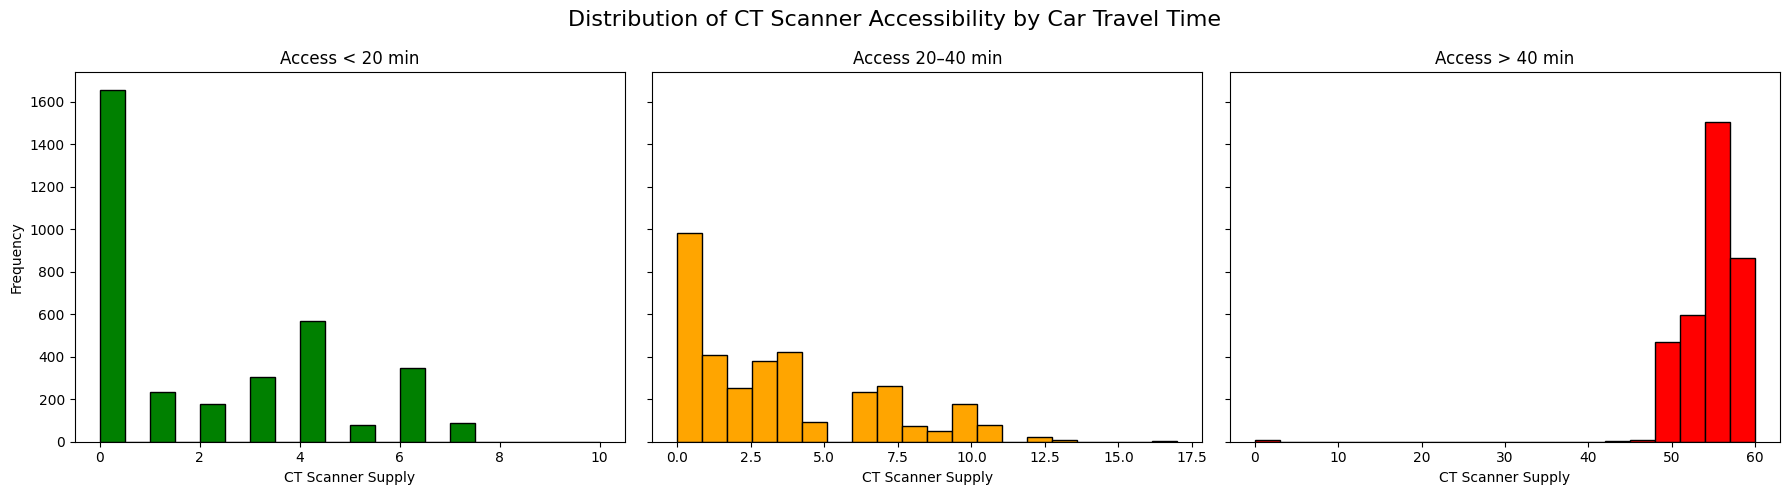

In [8]:
# Preview updated gdf_lsoa
print("Sample of LSOA Accessibility Scores:")
display(gdf_lsoa[["lsoa21cd", "ct_access_car_lt_20", "ct_access_car_20_40", "ct_access_car_gt_40"]].head())

# Plot histograms for each time band
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

gdf_lsoa["ct_access_car_lt_20"].plot.hist(bins=20, ax=axes[0], color="green", edgecolor="black")
axes[0].set_title("Access < 20 min")
axes[0].set_xlabel("CT Scanner Supply")

gdf_lsoa["ct_access_car_20_40"].plot.hist(bins=20, ax=axes[1], color="orange", edgecolor="black")
axes[1].set_title("Access 20–40 min")
axes[1].set_xlabel("CT Scanner Supply")

gdf_lsoa["ct_access_car_gt_40"].plot.hist(bins=20, ax=axes[2], color="red", edgecolor="black")
axes[2].set_title("Access > 40 min")
axes[2].set_xlabel("CT Scanner Supply")

plt.suptitle("Distribution of CT Scanner Accessibility by Car Travel Time", fontsize=16)
plt.tight_layout()
plt.show()


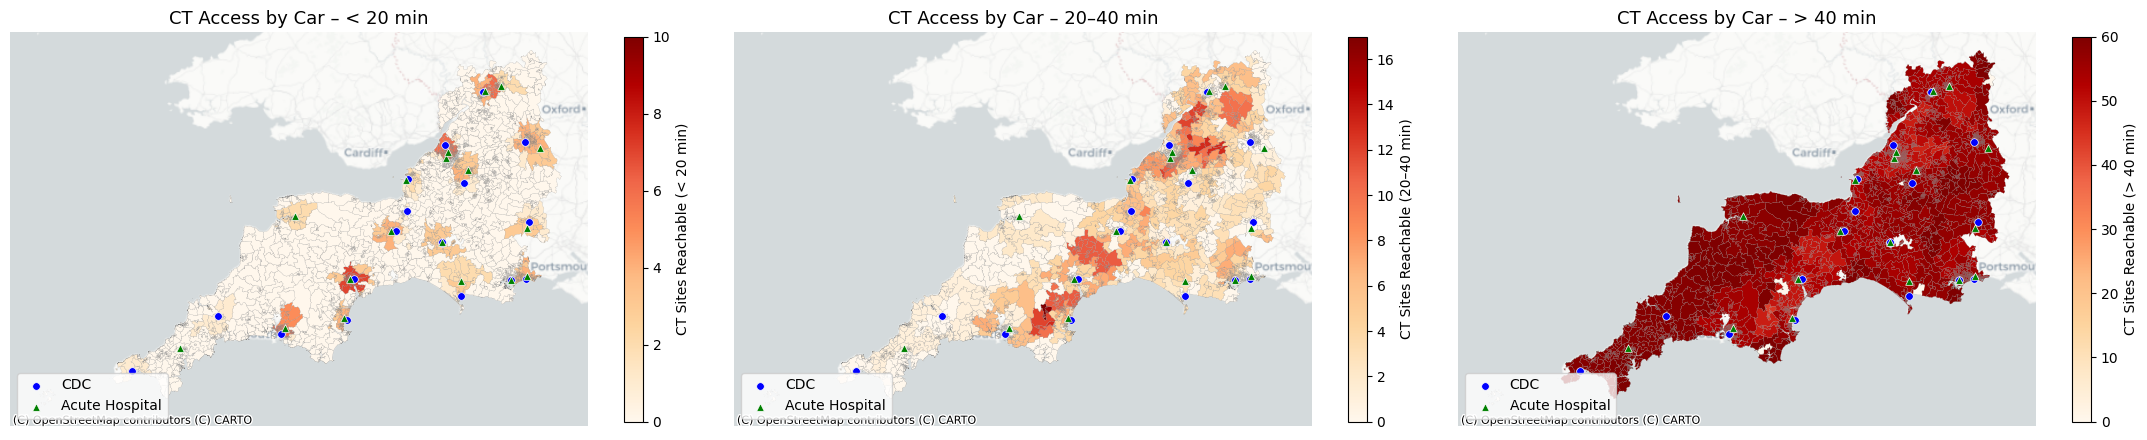

In [9]:
# ----------------------------------------------------------
# Step 4 – Multi-Panel Map: CT Access by Car (3 Travel Time Bands)
# ----------------------------------------------------------

import matplotlib.pyplot as plt

# Define columns and labels
access_cols = {
    'ct_access_car_lt_20': '< 20 min',
    'ct_access_car_20_40': '20–40 min',
    'ct_access_car_gt_40': '> 40 min'
}

# Create subplots for each access band
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 8))

for ax, (col, label) in zip(axes, access_cols.items()):
    
    # Extract geometry and access column
    gdf_band = gdf_lsoa[["lsoa21cd", "geometry", col]].copy()
    
    # Plot base LSOA layer
    gdf_band.plot(
        column=col,
        cmap="OrRd",
        linewidth=0.1,
        edgecolor="grey",
        legend=True,
        legend_kwds={"label": f"CT Sites Reachable ({label})", "shrink": 0.5},
        ax=ax
    )
    
    # Plot CDCs
    cdc_gdf.plot(
        ax=ax,
        color="blue",
        markersize=30,
        marker="o",
        edgecolor="white",
        linewidth=0.5,
        label="CDC"
    )
    
    # Plot Acute Hospitals
    acute_gdf.plot(
        ax=ax,
        color="green",
        markersize=30,
        marker="^",
        edgecolor="white",
        linewidth=0.5,
        label="Acute Hospital"
    )
    
    # Format
    ax.set_title(f"CT Access by Car – {label}", fontsize=13)
    ax.axis("off")
    ax.legend(loc="lower left", frameon=True)

    # Basemap
    ctx.add_basemap(ax, crs=gdf_lsoa.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Final layout
plt.tight_layout()
plt.show()


Number of LSOAs with 0 CT access even at >40 mins: 7


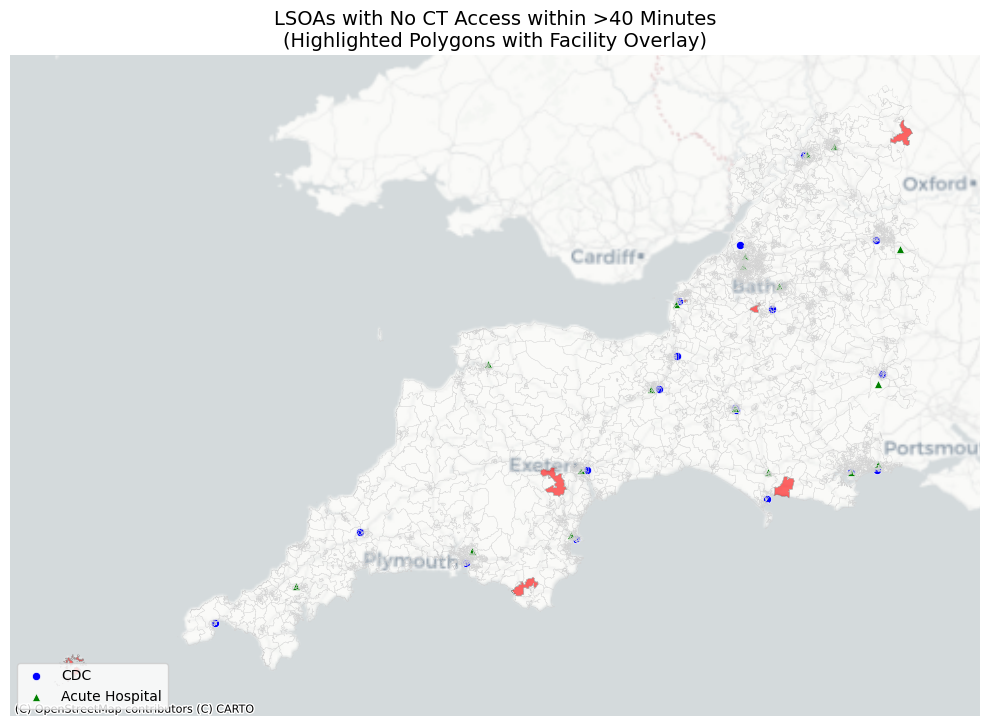

In [10]:
# ----------------------------------------------------------
# Step 5 – Highlight LSOAs with No CT Site Access in >40 mins
# ----------------------------------------------------------

# 5.1 – Filter LSOAs with zero access even beyond 40 minutes
gdf_zero_gt40 = gdf_lsoa[gdf_lsoa['ct_access_car_gt_40'] == 0].copy()
print(f"Number of LSOAs with 0 CT access even at >40 mins: {gdf_zero_gt40.shape[0]}")

# 5.2 – Plot map with highlighted LSOA polygons
fig, ax = plt.subplots(figsize=(10, 10))

# Base: all LSOA outlines for context
gdf_lsoa.boundary.plot(ax=ax, color='lightgrey', linewidth=0.2)

# Highlight: underserved LSOAs as filled red polygons
gdf_zero_gt40.plot(
    ax=ax,
    facecolor='red',
    edgecolor='black',
    linewidth=0.3,
    alpha=0.6,
    label='LSOA >40min No Access'
)

# Overlay: CDCs (blue circles)
cdc_gdf.plot(
    ax=ax,
    color='blue',
    marker='o',
    markersize=35,
    edgecolor='white',
    linewidth=0.5,
    label='CDC'
)

# Overlay: Acute Hospitals (green triangles)
acute_gdf.plot(
    ax=ax,
    color='green',
    marker='^',
    markersize=35,
    edgecolor='white',
    linewidth=0.5,
    label='Acute Hospital'
)

# Final map formatting
ax.set_title("LSOAs with No CT Access within >40 Minutes\n(Highlighted Polygons with Facility Overlay)", fontsize=14)
ax.axis('off')
ax.legend(loc='lower left', frameon=True)

# Basemap
ctx.add_basemap(ax, crs=gdf_lsoa.crs.to_string(), source=ctx.providers.CartoDB.Positron)

plt.tight_layout()
plt.show()


In [12]:
# ----------------------------------------------------------
# Step 6 – Export Final LSOA Accessibility GeoDataFrame
# ----------------------------------------------------------

# Reload full demographic and demand data from original GPKG
gdf_base = gpd.read_file(lsoa_gpkg_path)[[
    "lsoa21cd", "ct_total_demand", "total_population"
]]

# Merge with accessibility scores and geometry
gdf_lsoa_export = gdf_lsoa.merge(gdf_base, on="lsoa21cd", how="left")

# Define output path
export_path = os.path.join(
    processed_dir,
    "gdf_lsoa_CT_accessibility_2024.gpkg"
)

# Save final export
gdf_lsoa_export.to_file(export_path, driver="GPKG")
print(f"Export complete: {export_path}")


Export complete: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/gdf_lsoa_CT_accessibility_2024.gpkg
